In [1]:
import phi.physics._boundaries
from phi.torch.flow import *

math.set_global_precision(32)
TORCH.set_default_device("GPU")
device = torch.device("cuda")

In [21]:
RE_FAC_SOL = 10 / (128 * 128)
import phi.physics.diffuse


class KarmanFlow:
    def __init__(self, domain):
        self.domain = domain
        self.vel_BcMask = self.domain.staggered_grid(HardGeometryMask(Box(y=(None, 5), x=None)))
        self.inflow = self.domain.scalar_grid(Box(y=(5, 10), x=(25, 75)))  # scale with domain if necessary!
        self.obstacles = [Obstacle(Sphere(center=tensor([50, 50], channel(vector="y,x")), radius=10))]
        self.solve_info = {}

    def step(self, marker_in, velocity_in, Re, res, dt=1.0):
        velocity = velocity_in
        marker = marker_in
        Re_phiflow = Re / RE_FAC_SOL
        velocity = phi.physics.diffuse.explicit(u=velocity, diffusivity=1.0 / Re_phiflow * dt * res * res, dt=dt)
        velocity = velocity * (1.0 - self.vel_BcMask) + self.vel_BcMask * (1, 0)
        marker = advect.semi_lagrangian(marker + 1. * self.inflow, velocity, dt=dt)
        velocity = advected_velocity = advect.semi_lagrangian(velocity, velocity, dt=dt)
        velocity, pressure = fluid.make_incompressible(velocity, self.obstacles)
        self.solve_info = {'pressure': pressure, 'advected_velocity': advected_velocity}
        return [marker, velocity]

In [10]:
network = res_net(in_channels=3, out_channels=2, layers=[32, 32, 32])
for m in network.modules():
    if isinstance(m, torch.nn.Conv2d):
        torch.nn.init.xavier_uniform_(m.weight, gain=0.1)
optimizer = adam(network, 1e-3)

In [12]:
import pbdl.torch.loader

MSTEPS = 4
BATCH_SIZE = 3
dataloader = pbdl.torch.loader.Dataloader("solver-in-the-loop-wake-flow", MSTEPS, shuffle=True,
                                          sel_sims=[0, 1, 2, 3, 4, 5],
                                          batch_size=BATCH_SIZE, normalize_const="std", normalize_data="std",
                                          intermediate_time_steps=True)

download completed	 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100%6m
Success: Loaded solver-in-the-loop-wake-flow with 10 simulations (6 selected) and 496 samples each.
Info: No precomputed normalization data found (or not complete). Calculating data...


In [20]:
SOURCE_RES = [64, 32]
BNDS = {
    'y': (phi.physics._boundaries.OPEN, phi.physics._boundaries.OPEN),
    'x': (phi.physics._boundaries.STICKY, phi.physics._boundaries.STICKY)
}
LENGTH = 100.
domain = phi.physics._boundaries.Domain(y=SOURCE_RES[0], x=SOURCE_RES[1], boundaries=BNDS,
                                        bounds=Box(y=2 * LENGTH, x=LENGTH))
simulator = KarmanFlow(domain=domain)

C:\Users\xayah\AppData\Local\Temp\ipykernel_25276\3899897705.py:7: DeprecationWarning: Domain is deprecated and will be removed in a future release. Use a dict instead, e.g. CenteredGrid(values, extrapolation, **domain_dict)
  domain = phi.physics._boundaries.Domain(y=SOURCE_RES[0], x=SOURCE_RES[1], boundaries=BNDS, bounds=Box(y=2*LENGTH, x=LENGTH))
C:\Users\xayah\AppData\Local\Temp\ipykernel_25276\3899897705.py:7: FutureWarning: Domain is deprecated and will be removed in a future release. Use a dict instead, e.g. CenteredGrid(values, extrapolation, **domain_dict)
  domain = phi.physics._boundaries.Domain(y=SOURCE_RES[0], x=SOURCE_RES[1], boundaries=BNDS, bounds=Box(y=2*LENGTH, x=LENGTH))


In [ ]:
@jit_compile
def simulation_step(marker,velocity,Re,resolution):
    m,v = simulator.step(
        marker_in=marker,
        velocity_in=velocity,
        Re=Re, res=resolution
    )
    return m,v

Batch 0
torch.Size([3, 4, 65, 32]) torch.Size([3, 4, 3, 65, 32])


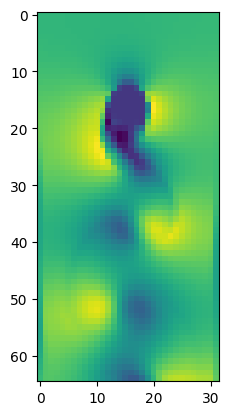

In [39]:
ip = None
tg = None
for batch_idx, (inputs, targets) in enumerate(dataloader):
    print(f"Batch {batch_idx}")
    print(inputs.shape, targets.shape)
    ip = inputs
    tg = targets
    break
import matplotlib.pyplot as plt
plt.imshow(tg[2, 2, 2].numpy())